In [1]:
import numpy as np
import psycopg2
import getpass
# for configuring connection 
from configobj import ConfigObj
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils import *

In [2]:
# Create a database connection using settings from config file
config='../db/config.ini'

# connection info
conn_info = dict()
if os.path.isfile(config):
    config = ConfigObj(config)
    conn_info["sqluser"] = config['username']
    conn_info["sqlpass"] = config['password']
    conn_info["sqlhost"] = config['host']
    conn_info["sqlport"] = config['port']
    conn_info["dbname"] = config['dbname']
    conn_info["schema_name"] = config['schema_name']
else:
    conn_info["sqluser"] = 'postgres'
    conn_info["sqlpass"] = ''
    conn_info["sqlhost"] = '192.168.60.144'
    conn_info["sqlport"] = 6432
    conn_info["dbname"] = 'eicu'
    conn_info["schema_name"] = 'public,eicu_crd'
    
# Connect to the eICU database
print('Database: {}'.format(conn_info['dbname']))
print('Username: {}'.format(conn_info["sqluser"]))
if conn_info["sqlpass"] == '':
    # try connecting without password, i.e. peer or OS authentication
    try:
        if (conn_info["sqlhost"] == '192.168.60.144') & (conn_info["sqlport"]=='6432'):
            con = psycopg2.connect(dbname=conn_info["dbname"],
                                   user=conn_info["sqluser"])            
        else:
            con = psycopg2.connect(dbname=conn_info["dbname"],
                                   host=conn_info["sqlhost"],
                                   port=conn_info["sqlport"],
                                   user=conn_info["sqluser"])
    except:
        conn_info["sqlpass"] = getpass.getpass('Password: ')

        con = psycopg2.connect(dbname=conn_info["dbname"],
                               host=conn_info["sqlhost"],
                               port=conn_info["sqlport"],
                               user=conn_info["sqluser"],
                               password=conn_info["sqlpass"])
query_schema = 'set search_path to ' + conn_info['schema_name'] + ';'

Database: eicu
Username: postgres


In [3]:
from sqlalchemy import create_engine,text

con = create_engine(
    f'postgresql://{conn_info["sqluser"]}:{conn_info["sqlpass"]}@{conn_info["sqlhost"]}:{conn_info["sqlport"]}/{conn_info["dbname"]}',
    connect_args={'options': '-c search_path=eicu_crd'}
)

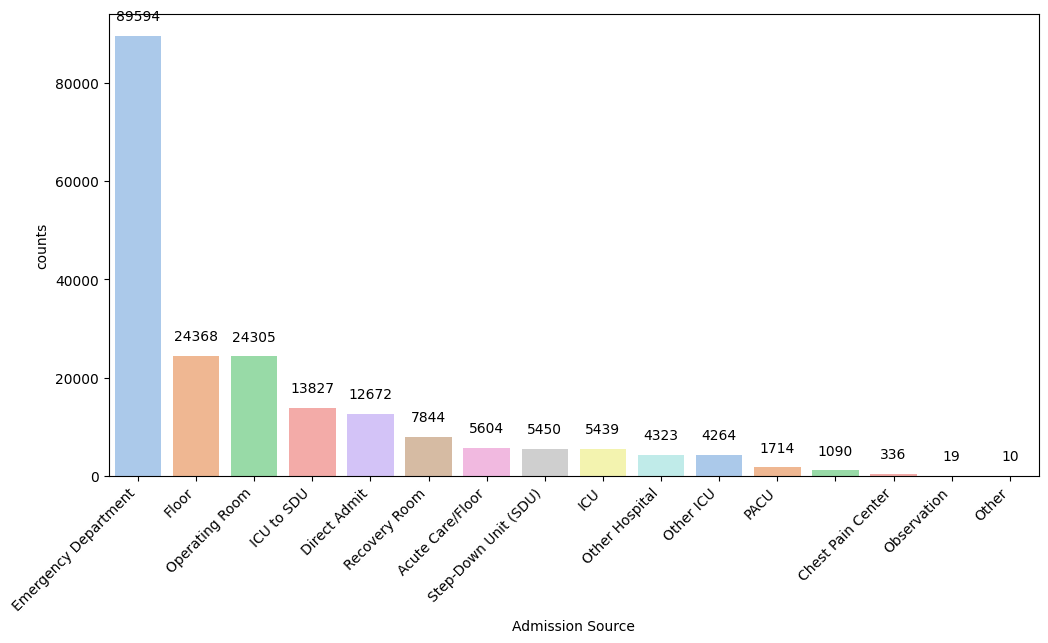

there are 200859 patiets and 200859 records


In [4]:
create_table_query = """
drop materialized view if exists flat cascade;
create materialized view flat as
SELECT DISTINCT patientunitstayid, gender, age,unitadmitsource, apacheadmissiondx, admissionweight,dischargeweight, unitdischargelocation,unitdischargestatus
FROM patient
group by patientunitstayid
order by patientunitstayid;
"""

with con.begin() as connection:  
    connection.execute(text(create_table_query))
    
select_query = "SELECT * FROM flat;"
df_flat = pd.read_sql_query(select_query, con)
counts=df_flat["unitadmitsource"].value_counts()

plot_counts(counts, "Admission Source")
print("there are {} patiets and {} records".format(df_flat["patientunitstayid"].nunique(),df_flat["patientunitstayid"].count()))

In [5]:
create_table_query = """
drop materialized view if exists flat cascade;
create materialized view flat as
SELECT DISTINCT patientunitstayid, gender, age,unitadmitsource, unitdischargeoffset, apacheadmissiondx, admissionweight,dischargeweight, unitdischargelocation,unitdischargestatus
FROM patient
WHERE unitadmitsource IN ('Emergency Department', 'Operating Room', 'Floor', 'Direct Admit','Recovery Room') 
      AND   unitdischargeoffset > 0
group by patientunitstayid
order by patientunitstayid;
"""

with con.begin() as connection:  
    connection.execute(text(create_table_query))
    
select_query = "SELECT * FROM flat;"
df_flat_1 = pd.read_sql_query(select_query, con)
print("there are {} patiets and {} records".format(df_flat_1["patientunitstayid"].nunique(),df_flat_1["patientunitstayid"].count()))

there are 158323 patiets and 158323 records


In [6]:
los_days= count_los(df_flat_1)

the 29.6% of patients have a length of stay of 1.0 days or less
the 59.2% of patients have a length of stay of 2.0 days or less
the 74.3% of patients have a length of stay of 3.0 days or less
the 82.4% of patients have a length of stay of 4.0 days or less
the 87.2% of patients have a length of stay of 5.0 days or less
the 90.3% of patients have a length of stay of 6.0 days or less
the 92.4% of patients have a length of stay of 7.0 days or less
the 95.8% of patients have a length of stay of 10.0 days or less
the 97.9% of patients have a length of stay of 14.0 days or less
the minimum los is 1.0 and the maximum los is 507.0
count    158323.000000
mean          3.276536
std           4.392630
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max         507.000000
Name: unitdischargeoffset, dtype: float64


In [7]:
create_table_query = """
drop materialized view if exists flat cascade;
create materialized view flat as
SELECT DISTINCT patientunitstayid, gender, age,unitadmitsource, unitdischargeoffset, apacheadmissiondx, admissionweight,dischargeweight, unitdischargelocation,unitdischargestatus
FROM patient
WHERE unitadmitsource IN ('Emergency Department', 'Operating Room', 'Floor', 'Direct Admit','Recovery Room') 
      AND   unitdischargeoffset > 360
      AND   unitdischargeoffset < 14400 
group by patientunitstayid
order by patientunitstayid;      
"""

with con.begin() as connection:  
    connection.execute(text(create_table_query))
    
select_query = "SELECT * FROM flat;"
df_flat_2 = pd.read_sql_query(select_query, con)
print("there are {} patiets and {} records".format(df_flat_2["patientunitstayid"].nunique(),df_flat_2["patientunitstayid"].count()))

there are 145300 patiets and 145300 records


In [8]:
csv= '/home/mei/nas/docker/thesis/data/csv/'
df_flat_2.to_csv(csv+'flat.csv',index=False)

In [8]:
missing_ratio = pd.DataFrame(df_flat_2.isna().sum() / len(df_flat_2.index), columns = ['missing ratio %']) * 100
missing_ratio.sort_values('missing ratio %', inplace = True, ascending = False) 
missing_ratio

,missing ratio %
dischargeweight,42.267034
admissionweight,2.851342
patientunitstayid,0.000000
gender,0.000000
age,0.000000
unitadmitsource,0.000000
unitdischargeoffset,0.000000
apacheadmissiondx,0.000000
unitdischargelocation,0.000000
unitdischargestatus,0.000000


## gender

In [9]:
freq_gender = pd.DataFrame()
freq_gender['noAnnotations'] = df_flat_2['gender'].value_counts() 
freq_gender['%'] = df_flat_2['gender'].value_counts() / len(df_flat_2.index) * 100
freq_gender

,noAnnotations,%
gender,,
Male,78134,53.774260
Female,67085,46.169993
,54,0.037164
Unknown,19,0.013076
Other,8,0.005506


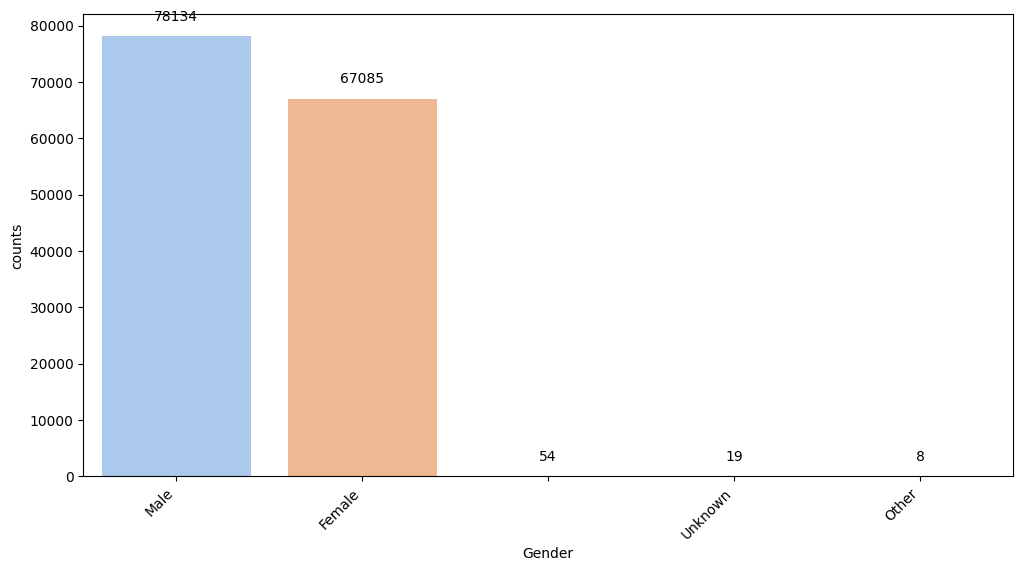

In [10]:
gender_counts = df_flat_2['gender'].value_counts()
plot_counts(gender_counts,"Gender")

## age

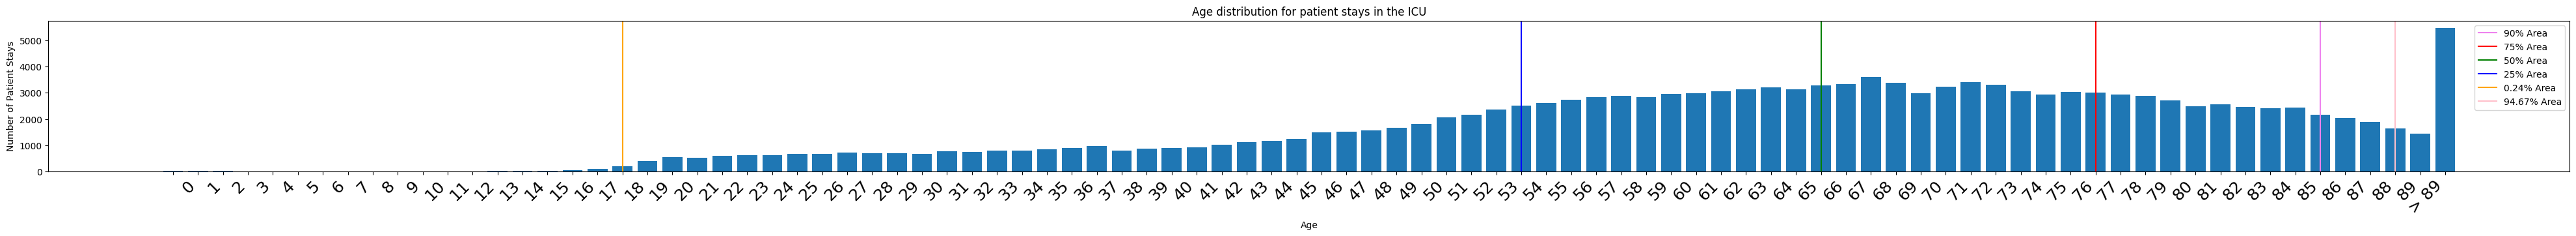

In [12]:
from natsort import natsorted 
from scipy import stats

age_distribution = df_flat_2.groupby('age', dropna = True)['age'].count()
labels = natsorted(list(age_distribution.index))
labels = [label for label in labels if not 'nan' in str(label)]
x = range(len(labels))  
ages = dict(zip(x, labels))
heights = list([age_distribution[label] for label in labels])

ages = list()
for i, count in enumerate(heights):
    [ages.append(i) for _ in range(count)]
    
percentile_90 = np.percentile(ages, 90)
percentile_75 = np.percentile(ages, 75)
percentile_50 = np.percentile(ages, 50)
percentile_25 = np.percentile(ages, 25)

score_18 = stats.percentileofscore(ages, 18)
score_89 = stats.percentileofscore(ages, 89)

plt.xticks(x, labels, rotation=45, ha="right", fontsize=18)  

plt.bar(x, heights)
plt.axvline(x=percentile_90, color = 'violet', label = '90% Area')
plt.axvline(x=percentile_75, color = 'red', label = '75% Area')
plt.axvline(x=percentile_50, color = 'green', label = '50% Area')
plt.axvline(x=percentile_25, color = 'blue', label = '25% Area')
plt.axvline(x=18, color = 'orange', label = '{}% Area'.format(round(score_18, 2)))
plt.axvline(x=89, color = 'pink', label = '{}% Area'.format(round(score_89, 2)))
plt.xticks(x, labels)
plt.rcParams["figure.figsize"] = (50,3)
plt.xlabel('Age')
plt.ylabel('Number of Patient Stays')
plt.title('Age distribution for patient stays in the ICU')
plt.legend()
plt.show()

## unitdischargelocation

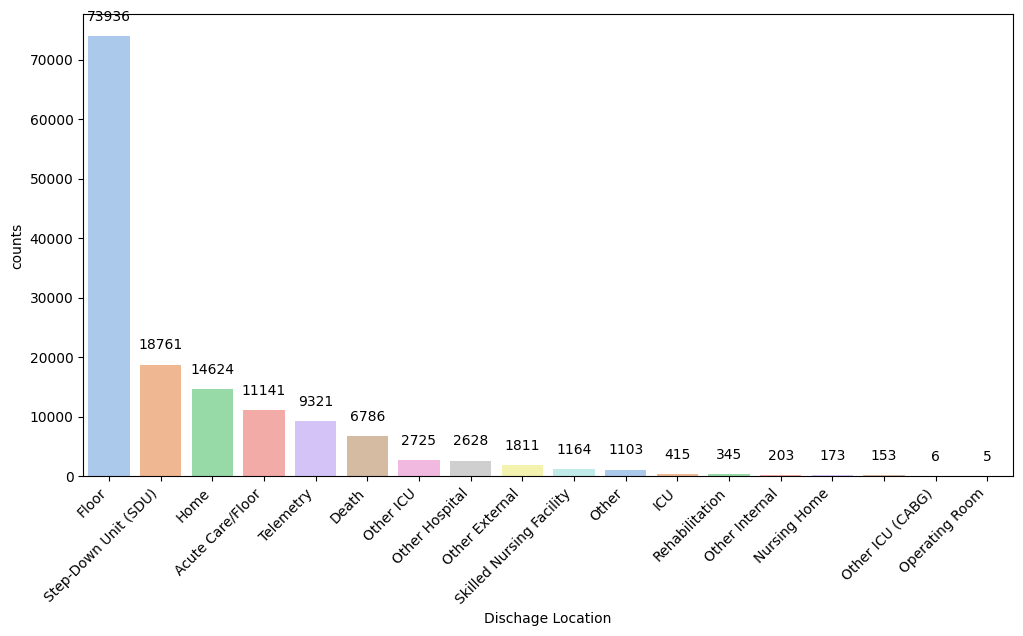

In [13]:
location = df_flat_2['unitdischargelocation'].value_counts() 
plot_counts(location,"Dischage Location")

## unitdischargestatus

In [14]:
freq_s = pd.DataFrame()
freq_s['noAnnotations'] = df_flat_2['unitdischargestatus'].value_counts() 
freq_s['%'] = df_flat_2['unitdischargestatus'].value_counts() / len(df_flat_2.index) * 100
freq_s

,noAnnotations,%
unitdischargestatus,,
Alive,138507,95.324845
Expired,6786,4.670337
,7,0.004818


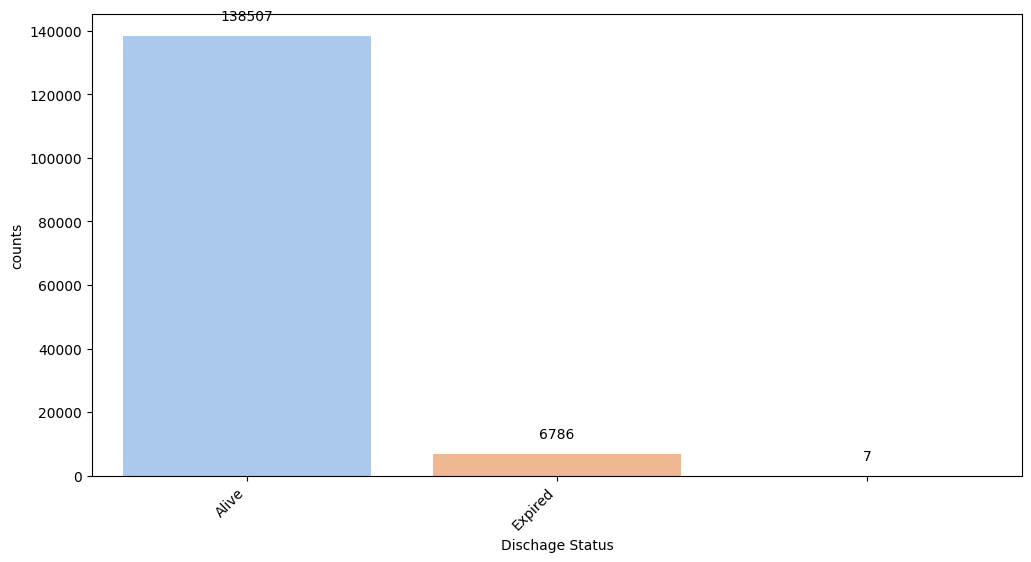

In [15]:
status = df_flat_2['unitdischargestatus'].value_counts()
plot_counts(status,"Dischage Status")

In [16]:
df_flat_2.describe(percentiles=[0.001, 0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99, 0.999])

,patientunitstayid,unitdischargeoffset,admissionweight,dischargeweight
count,1.453000e+05,145300.000000,141157.000000,83886.000000
mean,1.752024e+06,3261.882505,83.538926,84.077188
std,1.001501e+06,2693.001757,26.752755,35.866573
min,1.411680e+05,361.000000,0.000000,0.000000
0.1%,1.427019e+05,369.000000,27.715600,18.988500
1%,1.563058e+05,445.990000,40.800000,32.300000
5%,2.165718e+05,719.950000,49.900000,48.100000
25%,9.609262e+05,1369.000000,66.000000,66.400000
50%,1.674626e+06,2436.000000,79.700000,80.600000
75%,2.758755e+06,4185.000000,96.200000,97.700000


In [17]:
flat = df_flat_2.copy()
flat = process_flat(flat)

=====processing flat table=====
step1, keep the patients only with male and female
there are 145219 patients in the  and 145219 records in flat
step2, keep the patients only with age >=18 and mark the age > 89 as >89
there are 144812 patients in the  and 144812 records in flat
step3, for admission weight and discharge weight: fill the nan with mean,drop <0.1 and >99.9 quantile
there are 144523 patients in the  and 144523 records in flat
step4, keep the patient that only in Alive and Expired status
there are 144516 patients in the  and 144516 records in flat
step5, classify the discharge location to 4 categories
there are 134234 patients in the  and 134234 records in flat


In [19]:
flat.reset_index(inplace=True)

In [20]:
from sqlalchemy import text

with con.begin() as conn:
    conn.execute(text("DROP MATERIALIZED VIEW IF EXISTS flat CASCADE;"))
    conn.execute(text("DROP TABLE IF EXISTS temp_flat CASCADE;"))
flat.to_sql(
    name="temp_flat", con=con, if_exists="replace",  index=False)

create_mv_query = """
drop materialized view if exists flat cascade;
create materialized view flat as
SELECT 
 patient, gender, age, unitdischargeoffset,	 apacheadmissiondx,	admissionweight,dischargeweight,unitdischargestatus,unitdischargelocation,larger_than_89,discharge_risk_category
									
FROM temp_flat;
"""
with con.begin() as conn:
    conn.execute(text(create_mv_query))



In [21]:
df_mv = pd.read_sql("SELECT * FROM flat ", con)
df_mv

,patient,gender,age,unitdischargeoffset,apacheadmissiondx,admissionweight,dischargeweight,unitdischargestatus,unitdischargelocation,larger_than_89,discharge_risk_category
0,141168,0,70.0,3596,"Rhythm disturbance (atrial, supraventricular)",84.3,85.8,1,Death,0,3
1,141194,1,68.0,4813,"Sepsis, renal/UTI (including bladder)",73.9,76.7,0,Floor,0,1
2,141203,0,77.0,1869,"Arrest, respiratory (without cardiac arrest)",70.2,70.3,0,Floor,0,1
3,141208,0,25.0,720,"Overdose, sedatives, hypnotics, antipsychotics...",95.3,95.3,0,Home,0,0
4,141244,1,59.0,3835,"Graft, femoral-popliteal bypass",92.3,94.4,0,Floor,0,1
...,...,...,...,...,...,...,...,...,...,...,...
134229,3353216,0,50.0,3090,"Cystectomy, other reasons",55.4,61.8,0,Home,0,0
134230,3353226,0,79.0,11513,"Effusions, pleural",58.4,55.1,1,Death,0,3
134231,3353235,1,50.0,1069,"CHF, congestive heart failure",90.0,99.2,0,Telemetry,0,2
134232,3353237,0,79.0,1269,"Embolus, pulmonary",78.4,81.4,0,Step-Down Unit (SDU),0,2


In [22]:
create_table_query = query_schema + """
DROP MATERIALIZED VIEW  IF EXISTS labels CASCADE;
CREATE MATERIALIZED VIEW labels AS
SELECT DISTINCT (f.*), apr.actualiculos
FROM flat AS f
INNER JOIN apachepatientresult AS apr 
ON apr.patientunitstayid = f.patient;

CREATE UNIQUE INDEX idx_labels_patient ON labels (patient);

"""
with con.begin() as connection:  
    connection.execute(text(create_table_query))
    
select_query = "SELECT * FROM labels;"
df_labels = pd.read_sql_query(select_query, con)
print("there are {} patiets and {} records".format(df_labels["patient"].nunique(),df_labels["patient"].count()))

there are 119583 patiets and 119583 records


In [23]:
df_labels

,patient,gender,age,unitdischargeoffset,apacheadmissiondx,admissionweight,dischargeweight,unitdischargestatus,unitdischargelocation,larger_than_89,discharge_risk_category,actualiculos
0,1840548,1,61.0,8710,"CVA, cerebrovascular accident/stroke",113.4,84.1,0,Floor,0,1,6.0486
1,977367,0,69.0,7120,"Sepsis, pulmonary",104.3,102.3,1,Death,0,3,4.9444
2,439487,0,57.0,9022,"Respiratory - medical, other",83.6,84.1,1,Death,0,3,6.2652
3,1998934,1,62.0,1136,Diabetic ketoacidosis,81.6,81.8,0,Acute Care/Floor,0,2,0.7888
4,3333652,0,65.0,4146,Aortic and Mitral valve replacement,80.0,80.4,0,Telemetry,0,2,2.8791
...,...,...,...,...,...,...,...,...,...,...,...,...
119578,532847,1,78.0,11048,Cardiac arrest (with or without respiratory ar...,83.6,80.9,1,Death,0,3,7.6722
119579,849291,1,71.0,3121,"Neurologic medical, other",106.8,102.6,0,Step-Down Unit (SDU),0,2,2.1673
119580,770787,1,73.0,835,"CVA, cerebrovascular accident/stroke",79.5,80.0,0,Step-Down Unit (SDU),0,2,0.5798
119581,2360680,0,89.0,1818,"CHF, congestive heart failure",55.1,55.1,0,Acute Care/Floor,0,2,1.2625


In [26]:
csv = '/home/mei/nas/docker/thesis/data/csv/'
df_labels.to_csv(csv+'flat_labels.csv',index=False)

In [27]:
print('==> Loading data from labels and flat features files...')
flat = pd.read_csv(csv + 'flat_labels.csv')
print("there are {} patients in the  and {} records in flat".format(flat['patient'].nunique(), flat.shape[0]))

==> Loading data from labels and flat features files...
there are 119583 patients in the  and 119583 records in flat


In [5]:
query = query_schema + """
select distinct(f.patient), gender, age, admissionweight,larger_than_89 
from flat f
inner join id on f.patient = id.patient
order by patient;
"""
flat = pd.read_sql_query(query, con)
print("there are {} patients in the  and {} records in flat".format(flat['patient'].nunique(), flat.shape[0]))

there are 3072 patients in the  and 3072 records in flat


In [7]:
hdf= '/home/mei/nas/docker/thesis/data/hdf/'
flat.to_hdf(hdf + 'final_flat.h5', key='df',complevel=5, complib="zlib")

In [7]:
hdf= '/home/mei/nas/docker/thesis/data/hdf/'

flat = pd.read_hdf(hdf + 'final_flat_drug.h5', key='df')
flat

,patient,gender,age,admissionweight,larger_than_89,acetaminophen,advair_diskus,albuterol,albuterol_sulfate,allopurinol,...,tramadol_hcl,trazodone_hcl,tylenol,vancomycin,ventolin_hfa,vicodin,vitamin_c,vitamin_d,warfarin_sodium,zofran
0,260132,0,1.000000,0.139241,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,261021,0,1.000000,0.102278,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,270853,1,0.385714,0.521013,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,282833,0,0.928571,0.100253,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,306940,0,0.742857,0.253671,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3067,3246409,1,0.828571,0.260759,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3068,3246443,1,0.900000,0.228861,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3069,3246620,1,0.671429,0.379747,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3070,3246731,1,0.571429,0.328101,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [3]:
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
flat[['age','admissionweight']] = mm.fit_transform(flat[['age','admissionweight']])

In [4]:
flat

,patient,gender,age,admissionweight,larger_than_89,acetaminophen,advair_diskus,albuterol,albuterol_sulfate,allopurinol,...,trazodone_hcl,tylenol,vancomycin,ventolin_hfa,vicodin,vitamin_c,vitamin_d,warfarin_sodium,zofran,dmissionweight
0,260132,0,1.000000,0.139241,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.139241
1,261021,0,1.000000,0.102278,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.102278
2,270853,1,0.385714,0.521013,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0.521013
3,282833,0,0.928571,0.100253,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.100253
4,306940,0,0.742857,0.253671,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.253671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3067,3246409,1,0.828571,0.260759,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.260759
3068,3246443,1,0.900000,0.228861,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.228861
3069,3246620,1,0.671429,0.379747,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.379747
3070,3246731,1,0.571429,0.328101,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.328101


In [4]:
flat = flat.drop(columns=["dmissionweight"])

In [6]:
flat.to_hdf(hdf + 'final_flat_drug.h5', key='df',complevel=5, complib="zlib")